# Toy Model Implementation

In [1]:
import os

import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import pearsonr
import torch

import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from LEMBAS.model.bionetwork import format_network, SignalingModel
from LEMBAS.model.train import train_signaling_model
import LEMBAS.utilities as utils
from LEMBAS import plotting, io

In [2]:
n_cores = 12
utils.set_cores(n_cores)

seed = 49
if seed:
    torch.use_deterministic_algorithms(True)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    utils.set_seeds(seed = seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

## Load Input Data

In [3]:
# Prior knowledge signaling network
net = pd.read_csv('data/pkn_signaling.tsv', sep = '\t', index_col = False)

# Synthetic data input and output
# VESPA
'''x_data = pd.read_csv(os.path.join('data', 'vespa_x.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'vespa_xcell.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'vespa_xdrug.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'vespa_y.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'vespa_nodes_sites_map.csv'), sep=',', low_memory=False, index_col=0)'''

# DECRYPTM
'''x_data = pd.read_csv(os.path.join('data', 'decryptm_x.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'decryptm_xcell.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'decryptm_xdrug.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'decryptm_y.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'decryptm_nodes_sites_map.csv'), sep=',', low_memory=False, index_col=0)'''

# EGF
x_data = pd.read_csv(os.path.join('data', 'egf_x.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'egf_xcell.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'egf_xdrug.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'egf_y.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'egf_nodes_sites_map.csv'), sep=',', low_memory=False, index_col=0)

# EGF global
'''x_data = pd.read_csv(os.path.join('data', 'egf_x_global.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'egf_xcell_global.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'egf_xdrug_global.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'egf_y_global.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'egf_nodes_sites_map_global.csv'), sep=',', low_memory=False, index_col=0)'''

display(x_data.head())
display(x_cell.head())
display(x_drug.head())
display(y_data.head())
display(nodes_sites_map.head())

,EGF
Drug_CL,
EGF_R1,1.0
EGF_R2,1.0


,R1,R2
Drug_CL,,
EGF_R1,1,0
EGF_R2,0,1


,EGF
P01133,1


,1433E:P62258:S117s,1433E:P62258:S148s,1433E:P62258:S210s,1433E:P62258:S233s,1433E:P62258:Y152y,1433F:Q04917:S145s,1433G:P61981:S71s,1433S:P31947:S209s,1433S:P31947:S212s,1433S:P31947:S248s,...,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S288s,ZYX:Q15942:S290s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
EGF_R1_0,-0.030479,-0.657852,-0.246736,0.077428,-0.657852,0.462426,0.277434,0.729609,0.342797,0.070812,...,-0.363885,-1.527132,-1.502397,-1.001603,-0.658778,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.895855,-0.831304,-0.335641,-0.352439,-0.831304,-0.258492,-0.361850,0.125242,-0.454482,-0.287467,...,-0.045588,-1.714333,-1.979430,-1.257026,-1.126935,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_2,-1.141778,-0.457877,-0.540830,-0.032202,-0.457877,-0.250547,-0.622722,0.090442,-0.118990,-0.154651,...,-0.355034,-1.742520,-1.768622,-1.564773,-1.162622,0.518072,-1.181069,-2.107800,-2.655664,-1.195930
EGF_R2_2,-0.332935,-0.265399,-0.215251,0.190632,-0.265399,0.563662,0.074831,0.987148,0.674479,0.045946,...,-0.547265,-0.969857,-1.273527,-1.020154,-0.925320,-0.161955,-1.336020,-1.793863,-2.341803,-0.984556
EGF_R1_4,-0.297577,-0.007716,-0.170564,0.046843,-0.007716,0.434181,0.334414,0.880003,0.389008,0.008398,...,-1.120298,-1.350231,-1.428485,-0.924243,-0.833853,-0.087478,-1.260146,-1.440121,-1.283719,-1.306305


,A0MZ66,A1A4S6,A1L390,A1X283,A2RUS2,A6H8Y1,A6ND36,A7KAX9,A7MBM2,A7MCY6,...,Q9Y6M7,Q9Y6N7,Q9Y6Q6,Q9Y6Q9,Q9Y6R0,Q9Y6R4,Q9Y6W5,Q9Y6X0,Q9Y6X2,Q9Y6Y8
1433E:P62258:S117s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S148s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S210s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S233s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:Y152y,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Scaling down the problem to KEGG or SIGNOR
database = "KEGG"
net= net[net['sources'].str.contains(database, na=False)]
proteins_net = pd.concat([net['source'], net['target']], ignore_index=True).unique().tolist()

nodes_sites_map_sub = nodes_sites_map.loc[:, nodes_sites_map.columns.intersection(proteins_net)]
nodes_sites_map_sub = nodes_sites_map_sub[nodes_sites_map_sub.sum(axis=1) != 0]

phosphosites_keep = nodes_sites_map_sub.index
y_data = y_data.loc[:, y_data.columns.intersection(phosphosites_keep)]

display(nodes_sites_map_sub.head())
display(y_data.head())

,O00141,O00220,O00273,O00329,O00401,O00418,O00522,O14492,O14640,O14733,...,Q9Y4R8,Q9Y5V3,Q9Y624,Q9Y6D9,Q9Y6H5,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6R4,Q9Y6W5
1433E:P62258:S117s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S148s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S210s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S233s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:Y152y,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,1433E:P62258:S117s,1433E:P62258:S148s,1433E:P62258:S210s,1433E:P62258:S233s,1433E:P62258:Y152y,1433F:Q04917:S145s,1433T:P27348:S210s,1433T:P27348:S232s,1433T:P27348:S63s,1433T:P27348:S64s,...,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S288s,ZYX:Q15942:S290s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
EGF_R1_0,-0.030479,-0.657852,-0.246736,0.077428,-0.657852,0.462426,-0.072737,-0.178759,0.094034,0.690117,...,-0.363885,-1.527132,-1.502397,-1.001603,-0.658778,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.895855,-0.831304,-0.335641,-0.352439,-0.831304,-0.258492,-0.667643,-0.072726,0.005554,0.494495,...,-0.045588,-1.714333,-1.979430,-1.257026,-1.126935,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_2,-1.141778,-0.457877,-0.540830,-0.032202,-0.457877,-0.250547,-0.371070,-0.572024,0.022651,0.430511,...,-0.355034,-1.742520,-1.768622,-1.564773,-1.162622,0.518072,-1.181069,-2.107800,-2.655664,-1.195930
EGF_R2_2,-0.332935,-0.265399,-0.215251,0.190632,-0.265399,0.563662,0.341561,-0.368751,0.830756,0.796102,...,-0.547265,-0.969857,-1.273527,-1.020154,-0.925320,-0.161955,-1.336020,-1.793863,-2.341803,-0.984556
EGF_R1_4,-0.297577,-0.007716,-0.170564,0.046843,-0.007716,0.434181,0.228984,-0.331189,0.546906,0.678506,...,-1.120298,-1.350231,-1.428485,-0.924243,-0.833853,-0.087478,-1.260146,-1.440121,-1.283719,-1.306305


Starting nodes: ['P01133']
Number of nodes connected to 'P01133':
523


,O00141,O00273,O00329,O00401,O00418,O14492,O14733,O14745,O14920,O14950,...,Q9Y281,Q9Y2D8,Q9Y2Z0,Q9Y490,Q9Y4H2,Q9Y5V3,Q9Y624,Q9Y6K9,Q9Y6N7,Q9Y6W5
1433T:P27348:S210s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433T:P27348:S232s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433T:P27348:S63s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433T:P27348:S64s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3BP2:P78314:S225s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,1433T:P27348:S210s,1433T:P27348:S232s,1433T:P27348:S63s,1433T:P27348:S64s,3BP2:P78314:S225s,3BP2:P78314:S278s,3BP2:P78314:S416s,3BP2:P78314:S444s,4EBP1:Q13541:S101s,4EBP1:Q13541:S35s,...,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S288s,ZYX:Q15942:S290s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
EGF_R1_0,-0.072737,-0.178759,0.094034,0.690117,-0.654106,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,...,-0.363885,-1.527132,-1.502397,-1.001603,-0.658778,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.667643,-0.072726,0.005554,0.494495,-0.646513,-0.413584,-0.410982,-0.199704,-1.494197,-0.657824,...,-0.045588,-1.714333,-1.979430,-1.257026,-1.126935,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_2,-0.371070,-0.572024,0.022651,0.430511,0.126598,-0.368540,-0.367055,-0.150778,-1.577169,-0.843232,...,-0.355034,-1.742520,-1.768622,-1.564773,-1.162622,0.518072,-1.181069,-2.107800,-2.655664,-1.195930
EGF_R2_2,0.341561,-0.368751,0.830756,0.796102,0.667657,-0.139439,-0.091100,0.718152,-1.085383,-0.398227,...,-0.547265,-0.969857,-1.273527,-1.020154,-0.925320,-0.161955,-1.336020,-1.793863,-2.341803,-0.984556
EGF_R1_4,0.228984,-0.331189,0.546906,0.678506,0.796799,-0.434673,-0.179706,0.751016,-1.073060,-0.751673,...,-1.120298,-1.350231,-1.428485,-0.924243,-0.833853,-0.087478,-1.260146,-1.440121,-1.283719,-1.306305


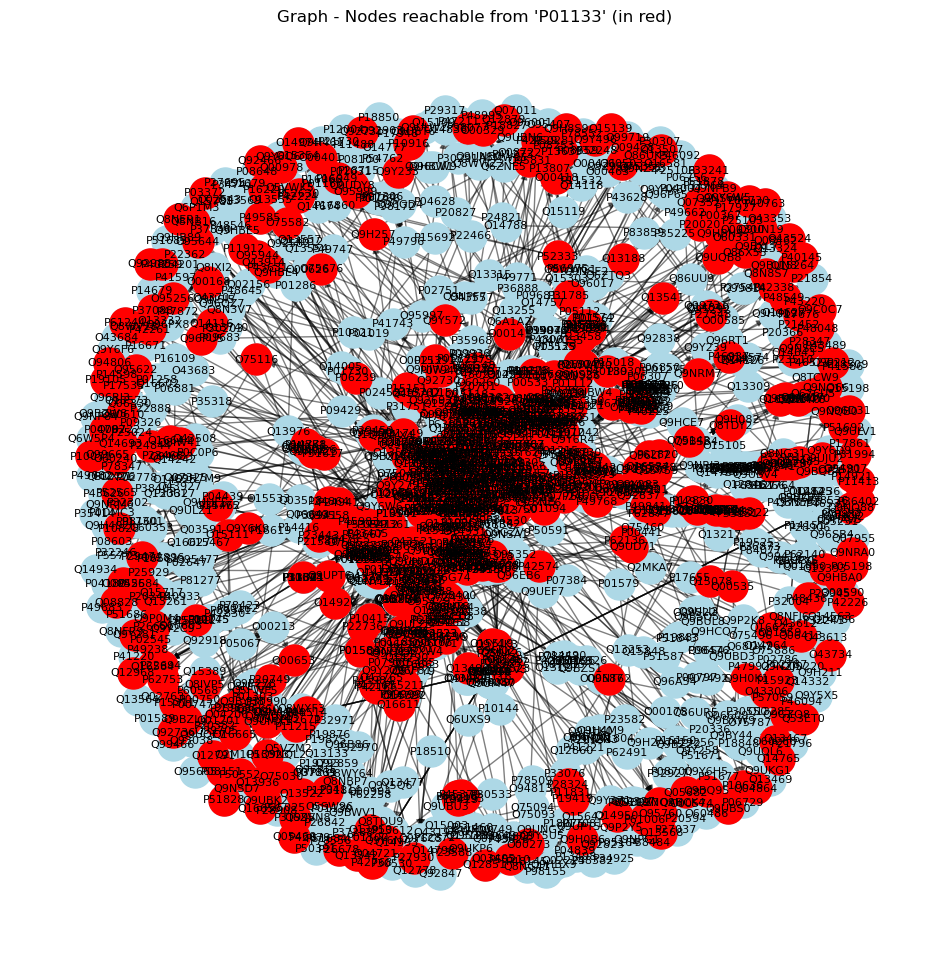

In [ ]:
# Filter nodes based on the networks input
G = nx.from_pandas_edgelist(net, source='source', target='target', create_using=nx.DiGraph())

start_nodes = list(x_drug.index)
print("Starting nodes:", start_nodes)

# Compute the reachable nodes from all start nodes.
reachable_nodes = set()
for node in start_nodes:
    if node in G:  # Only consider nodes present in the graph
        reachable_nodes.update(nx.descendants(G, node))
        reachable_nodes.add(node)
    else:
        print(f"Warning: Starting node {node} not found in graph.")

reachable_list = sorted(reachable_nodes)
print("Number of nodes connected to 'P01133':")
print(len(reachable_list))

# Filter dataframes
net = net[net['source'].isin(reachable_list) & net['target'].isin(reachable_list)]
proteins_net = pd.concat([net['source'], net['target']], ignore_index=True).unique().tolist()

nodes_sites_map_sub = nodes_sites_map_sub.loc[:, nodes_sites_map_sub.columns.intersection(proteins_net)]
nodes_sites_map_sub = nodes_sites_map_sub[nodes_sites_map_sub.sum(axis=1) != 0]

phosphosites_keep = nodes_sites_map_sub.index
y_data = y_data.loc[:, y_data.columns.intersection(phosphosites_keep)]

display(nodes_sites_map_sub.head())
display(y_data.head())

# Plot the graph
'''plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)

nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=500)
nx.draw_networkx_labels(G, pos, font_size=8)

nx.draw_networkx_nodes(G, pos,
                       nodelist=list(reachable_nodes),
                       node_color="red", node_size=500)
plt.title("Graph - Nodes reachable from 'P01133' (in red)")
plt.axis("off")
plt.show()'''

In [6]:
'''row_filter = "R2"

x_data = x_data[x_data.index.str.contains(row_filter)]
x_cell = x_cell[x_cell.index.str.contains(row_filter)]
#x_drug = x_drug[x_drug.index.str.contains(row_filter)]
y_data = y_data[y_data.index.str.contains(row_filter)]

display(x_data.head())
display(x_cell.head())
display(x_drug.head())
display(y_data.head())'''

'row_filter = "R2"\n\nx_data = x_data[x_data.index.str.contains(row_filter)]\nx_cell = x_cell[x_cell.index.str.contains(row_filter)]\n#x_drug = x_drug[x_drug.index.str.contains(row_filter)]\ny_data = y_data[y_data.index.str.contains(row_filter)]\n\ndisplay(x_data.head())\ndisplay(x_cell.head())\ndisplay(x_drug.head())\ndisplay(y_data.head())'

In [7]:
display(net.head())

,source,target,direction,stimulation,inhibition,sources,references,0
3,P17612,Q8NER1,1,1,0,HPRD_MIMP;KEGG;MIMP;PhosphoSite_MIMP;PhosphoSi...,TRIP:12194871,NaN
4,P12931,Q8NER1,1,1,0,KEGG;MIMP;NCI-PID_ProtMapper;PhosphoSite;Phosp...,PhosphoSite:16319926;ProtMapper:16319926;ProtM...,NaN
13,Q16539,P49137,1,1,0,ACSN;BEL-Large-Corpus_ProtMapper;BioGRID;CA1;C...,ACSN:11274345;ACSN:12738796;ACSN:15187187;ACSN...,NaN
16,O60674,P19235,1,1,0,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;...,BioGRID:8343951;Cellinker:9030561;HPRD-phos:12...,NaN
17,P19235,O60674,1,0,0,BioGRID;Cui2007;HPRD;KEGG-MEDICUS;SignaLink3;Wang,BioGRID:8343951;HPRD:11779507;HPRD:12441334;HP...,NaN


Let's see what the signaling network looks like:

In [8]:
stimulation_label = 'stimulation'
inhibition_label = 'inhibition'
weight_label = 'mode_of_action'
source_label = 'source'
target_label = 'target'

net[[source_label, target_label, stimulation_label, inhibition_label]].head()

,source,target,stimulation,inhibition
3,P17612,Q8NER1,1,0
4,P12931,Q8NER1,1,0
13,Q16539,P49137,1,0
16,O60674,P19235,1,0
17,P19235,O60674,0,0


Let's format it to fit with the necessary inputs to the SignalingModel:

In [9]:
net = format_network(net, weight_label = weight_label, stimulation_label = stimulation_label, inhibition_label = inhibition_label)
net[[source_label, target_label, weight_label, stimulation_label, inhibition_label]].head()

,source,target,mode_of_action,stimulation,inhibition
3,P17612,Q8NER1,1.0,1,0
4,P12931,Q8NER1,1.0,1,0
13,Q16539,P49137,1.0,1,0
16,O60674,P19235,1.0,1,0
17,P19235,O60674,0.1,0,0


## Define Parameters to Build and Train Model

In [10]:
# linear scaling of inputs/outputs
projection_amplitude_in = 3
projection_amplitude_out = 1.2
# other parameters
bionet_params = {'target_steps': 100, 'max_steps': 150, 'exp_factor':50, 'tolerance': 1e-5, 'leak':1e-2} # fed directly to model

# training parameters
lr_params = {'max_iter': 5000, 
             'learning_rate': 2e-3,
             'variable_lr': False}
other_params = {'lambda_dynamic': 1, 'batch_size': 10, 'noise_level': 10, 'gradient_noise_level': 1e-7}
regularization_params = {'param_lambda_L2': 1e-6, 'moa_lambda_L1': 0.1, 'ligand_lambda_L2': 1e-5, 'uniform_lambda_L2': 1e-4, 
                   'uniform_max': 1/projection_amplitude_out, 'spectral_loss_factor': 1e-5}
spectral_radius_params = {'n_probes_spectral': 5, 'power_steps_spectral': 50, 'subset_n_spectral': 10}
target_spectral_radius = 0.8
module_params = {
    'use_cln': True,
    'cln_hidden_layers': {1: 64, 2: 16},  # {1: 64, 2: 16}
    'use_xssn': True,
    'xssn_hidden_layers': None,
    'use_time': False,
    'n_timepoints': 5,
    'use_phospho': True,
    'nsl_hidden_layers': {1: 16, 2:8}, #{1: 16},
    'conn_dim': 5 #5
}

hyper_params = {**lr_params, **other_params, **regularization_params, **spectral_radius_params, **module_params}  # fed into training function | ** are used to combine multiple dictionaries -> it unpacks them

## Initialize Model
Next, let's initialize the model and format the inputs/outputs for running the model:

In [11]:
mod = SignalingModel(net = net,
                     X_in = x_data,
                     y_out = y_data, 
                     X_cell = x_cell,
                     X_drug = x_drug,
                     nodes_sites_map = nodes_sites_map_sub,
                     projection_amplitude_in = projection_amplitude_in, projection_amplitude_out = projection_amplitude_out,
                     weight_label = weight_label, source_label = source_label, target_label = target_label,
                     bionet_params = bionet_params, 
                     activation_function = 'MML',  # leaky_relu
                     dtype = torch.float32, device = device, seed = seed, module_params = module_params)

#X_in = mod.df_to_tensor(mod.X_in)
#y_out = mod.df_to_tensor(mod.y_out)

In [12]:
mod.X_in.head()

,EGF
Drug_CL,
EGF_R1,1.0
EGF_R2,1.0


In [13]:
mod.y_out.head()

,1433T:P27348:S210s,1433T:P27348:S232s,1433T:P27348:S63s,1433T:P27348:S64s,3BP2:P78314:S225s,3BP2:P78314:S278s,3BP2:P78314:S416s,3BP2:P78314:S444s,4EBP1:Q13541:S101s,4EBP1:Q13541:S35s,...,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S288s,ZYX:Q15942:S290s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
EGF_R1_0,-0.072737,-0.178759,0.094034,0.690117,-0.654106,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,...,-0.363885,-1.527132,-1.502397,-1.001603,-0.658778,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.667643,-0.072726,0.005554,0.494495,-0.646513,-0.413584,-0.410982,-0.199704,-1.494197,-0.657824,...,-0.045588,-1.714333,-1.979430,-1.257026,-1.126935,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_2,-0.371070,-0.572024,0.022651,0.430511,0.126598,-0.368540,-0.367055,-0.150778,-1.577169,-0.843232,...,-0.355034,-1.742520,-1.768622,-1.564773,-1.162622,0.518072,-1.181069,-2.107800,-2.655664,-1.195930
EGF_R2_2,0.341561,-0.368751,0.830756,0.796102,0.667657,-0.139439,-0.091100,0.718152,-1.085383,-0.398227,...,-0.547265,-0.969857,-1.273527,-1.020154,-0.925320,-0.161955,-1.336020,-1.793863,-2.341803,-0.984556
EGF_R1_4,0.228984,-0.331189,0.546906,0.678506,0.796799,-0.434673,-0.179706,0.751016,-1.073060,-0.751673,...,-1.120298,-1.350231,-1.428485,-0.924243,-0.833853,-0.087478,-1.260146,-1.440121,-1.283719,-1.306305


## Train Model

In [14]:
# model setup
mod.input_layer.weights.requires_grad = False # don't learn scaling factors for the ligand input concentrations
mod.signaling_network.prescale_weights(target_radius = target_spectral_radius) # spectral radius

# loss and optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam

# training loop
mod, cur_loss, cur_eig, mean_loss, stats, X_train, X_test, X_train_index, y_train, y_test, y_train_index, X_cell_train, X_cell_test, missing_node_indexes, floor_idx, ceil_idx, weight = train_signaling_model(
    mod, net, optimizer, loss_fn, reset_epoch = 200, hyper_params = hyper_params, train_split_frac = {'train': 1, 'test': 0}, train_seed = seed, 
    verbose = True, split_by = 'condition', noise_scale = 0.0) 

# store results
io.write_pickled_object(stats, os.path.join('data', 'training_stats_cond.pickle'))
torch.save(obj=mod.state_dict(), f=os.path.join('data', 'mac_state_dict_cond.pth'))

i=0, l=0.75535, s=0.747, r=0.00200, v=0
i=250, l=0.15690, s=0.499, r=0.00200, v=1
i=500, l=0.08018, s=0.813, r=0.00200, v=0
i=750, l=0.06599, s=0.800, r=0.00200, v=0
i=1000, l=0.06082, s=0.732, r=0.00200, v=0
i=1250, l=0.05837, s=0.475, r=0.00200, v=1
i=1500, l=0.05587, s=0.507, r=0.00200, v=1
i=1750, l=0.05400, s=0.543, r=0.00200, v=0
i=2000, l=0.05188, s=0.564, r=0.00200, v=0
i=2250, l=0.05120, s=0.578, r=0.00200, v=3
i=2500, l=0.05058, s=0.638, r=0.00200, v=0
i=2750, l=0.05020, s=0.557, r=0.00200, v=0
i=3000, l=0.04984, s=0.490, r=0.00200, v=0
i=3250, l=0.04958, s=0.582, r=0.00200, v=1
i=3500, l=0.04893, s=0.563, r=0.00200, v=2
i=3750, l=0.04854, s=0.588, r=0.00200, v=1
i=4000, l=0.04812, s=0.602, r=0.00200, v=1
i=4250, l=0.04800, s=0.583, r=0.00200, v=1
i=4500, l=0.04762, s=0.582, r=0.00200, v=1
i=4750, l=0.04751, s=0.572, r=0.00200, v=1
Training ran in: 9 min 31.63 sec


## Predict Using Model

In [15]:
mod.load_state_dict(torch.load(os.path.join('data', 'mac_state_dict_cond.pth'), map_location=torch.device('cpu')))
stats = io.read_pickled_object(os.path.join('data', 'training_stats_cond.pickle'))

C:\Users\kanto\AppData\Local\Temp\ipykernel_7636\560733483.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [16]:
X_in = mod.df_to_tensor(mod.X_in)
X_cell = mod.df_to_tensor(mod.X_cell)
mod.eval()
Y_hat, Y_full, Y_fullFull, Y_fullprotein = mod(X_in, X_cell, missing_node_indexes)  # to know which nodes are missing and should be excluded from the node-site mapping

In [17]:
'''nodes_sites_weights = mod.nodes_sites_layer.real_weights
print(nodes_sites_weights.shape)
weights_np = nodes_sites_weights.detach().cpu().numpy().flatten()
df_weights = pd.DataFrame({'Weight': weights_np})

p_hist = (
    p9.ggplot(df_weights, p9.aes(x='Weight')) +
    p9.geom_histogram(bins=30, fill="blue", color="black", alpha=0.7) +
    p9.labs(x="Weight Value", y="Count", title="Histogram of Nodes-Sites Mapping Weights") +
    p9.theme_bw()
)
p_hist.show()'''

'nodes_sites_weights = mod.nodes_sites_layer.real_weights\nprint(nodes_sites_weights.shape)\nweights_np = nodes_sites_weights.detach().cpu().numpy().flatten()\ndf_weights = pd.DataFrame({\'Weight\': weights_np})\n\np_hist = (\n    p9.ggplot(df_weights, p9.aes(x=\'Weight\')) +\n    p9.geom_histogram(bins=30, fill="blue", color="black", alpha=0.7) +\n    p9.labs(x="Weight Value", y="Count", title="Histogram of Nodes-Sites Mapping Weights") +\n    p9.theme_bw()\n)\np_hist.show()'

## Visualize

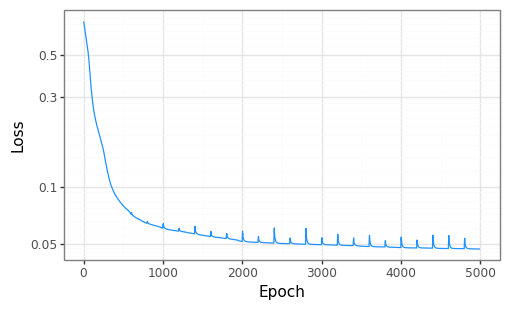

In [18]:
loss_smooth = utils.get_moving_average(values = stats['loss_mean'], n_steps = 5)
loss_sigma_smooth = utils.get_moving_average(values = stats['loss_sigma'], n_steps = 10)
epochs = np.array(range(stats['loss_mean'].shape[0]))

p1A = plotting.shade_plot(X = epochs, Y = loss_smooth, sigma = loss_sigma_smooth, x_label = 'Epoch', y_label = 'Loss')
p1A += p9.scale_y_log10()
p1A.draw()

As well as how the learning rate was adjusted across training:

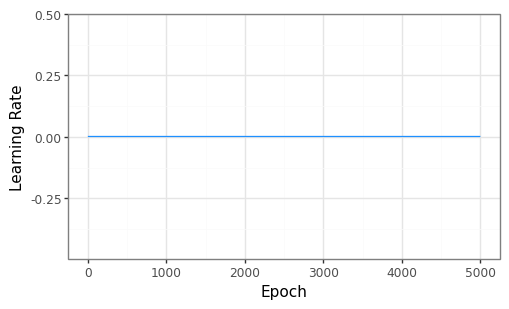

In [19]:
viz_df = pd.DataFrame(data = {'Epoch': epochs, 'lr': stats['learning_rate']})
width, height = 5, 3
p1B = (
    p9.ggplot(viz_df, p9.aes(x='Epoch', y = 'lr')) +
    p9.geom_line(color = '#1E90FF') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.ylab('Learning Rate')
)
p1B.draw()

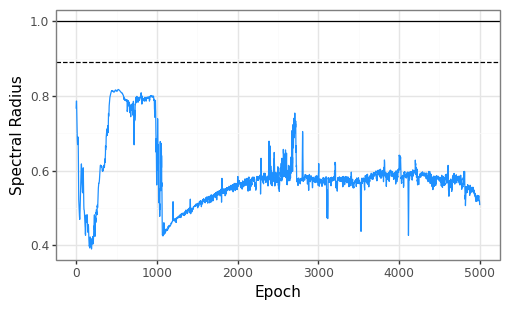

In [20]:
eig_smooth = utils.get_moving_average(stats['eig_mean'], 5)
eig_sigma_smooth = utils.get_moving_average(stats['eig_sigma'], 5)

p1C = plotting.shade_plot(X = epochs, Y = eig_smooth, sigma = eig_sigma_smooth, x_label = 'Epoch', y_label = 'Spectral Radius')
p1C += p9.geom_hline(yintercept = mod.signaling_network.training_params['spectral_target'], linetype="dashed", color="black")
p1C += p9.geom_hline(yintercept = 1, color="black")
p1C.draw()

Plot how the time mapping is changing across epochs

In [21]:
'''# Prepare the data for plotting
epochs = np.array(range(len(stats['mapping'])))
mapping_data = []

last_iteration_mapping = np.round(stats['mapping'][-1]).astype(int).tolist()  # Last values of mapping

for epoch, mapping in enumerate(stats['mapping']):
    for time_point, value in enumerate(mapping):
        time_point_name = last_iteration_mapping[time_point]
        mapping_data.append({'Epoch': epoch, 'Time Point': str(time_point_name), 'Value': value})

mapping_df = pd.DataFrame(mapping_data)
mapping_df['Time Point'] = pd.Categorical(mapping_df['Time Point'], categories=[str(tp) for tp in last_iteration_mapping], ordered=True)

# Real time points
real_time_points = [0, 1, 2, 3, 5, 10, 20, 50]
real_time_df = pd.DataFrame({'Real Time Points': real_time_points})

# Generate a color palette dictionary
color_palette = dict(zip(mapping_df['Time Point'].cat.categories, p9.scale_color_hue().palette(len(mapping_df['Time Point'].cat.categories))))

# Plot using plotnine
p = (
    p9.ggplot(mapping_df, p9.aes(x='Epoch', y='Value', color='Time Point')) +
    p9.geom_line(size=1) +
    p9.geom_hline(p9.aes(yintercept='Real Time Points'), data=real_time_df, color='black', linetype='dashed') +
    p9.scale_color_manual(values=color_palette) +
    p9.labs(x='Epoch', y='Time Mapping', color='Time Point') +
    p9.theme_classic()
)

p.draw()'''

"# Prepare the data for plotting\nepochs = np.array(range(len(stats['mapping'])))\nmapping_data = []\n\nlast_iteration_mapping = np.round(stats['mapping'][-1]).astype(int).tolist()  # Last values of mapping\n\nfor epoch, mapping in enumerate(stats['mapping']):\n    for time_point, value in enumerate(mapping):\n        time_point_name = last_iteration_mapping[time_point]\n        mapping_data.append({'Epoch': epoch, 'Time Point': str(time_point_name), 'Value': value})\n\nmapping_df = pd.DataFrame(mapping_data)\nmapping_df['Time Point'] = pd.Categorical(mapping_df['Time Point'], categories=[str(tp) for tp in last_iteration_mapping], ordered=True)\n\n# Real time points\nreal_time_points = [0, 1, 2, 3, 5, 10, 20, 50]\nreal_time_df = pd.DataFrame({'Real Time Points': real_time_points})\n\n# Generate a color palette dictionary\ncolor_palette = dict(zip(mapping_df['Time Point'].cat.categories, p9.scale_color_hue().palette(len(mapping_df['Time Point'].cat.categories))))\n\n# Plot using plotnin

### Model Benchmarking

Evaluate model. Plot correlation for each site after subtracting the time point zero from the site trajectory for each drug-cell line combination. Plot correlations across sites and across samples. Plot example site trajectory across cell lines and drugs.

torch.Size([10, 2157]) torch.Size([10, 2157])


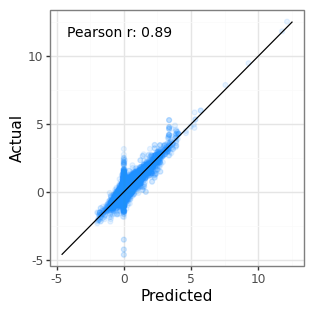

In [22]:
def subsample_Y(Y, floor_idx, ceil_idx, weight):
    """
    Subsample Y using the provided indices and weights.

    Parameters
    ----------
    Y : torch.Tensor
        The tensor to be subsampled.
    floor_idx : torch.Tensor
        The floor indices for subsampling.
    ceil_idx : torch.Tensor
        The ceil indices for subsampling.
    weight : torch.Tensor
        The interpolation weights.

    Returns
    -------
    Y_subsampled : torch.Tensor
        The subsampled tensor.
    """
    Y = Y.to('cpu')
    
    # Reduce dimensions of indices
    floor_idx_reduced = floor_idx[0, :, 0]
    ceil_idx_reduced = ceil_idx[0, :, 0]
    
    # Gather the corresponding hidden state outputs
    Y_floor = Y[:, floor_idx_reduced, :]  # (batch, K, feat)
    Y_ceil = Y[:, ceil_idx_reduced, :]  # (batch, K, feat)
    
    # Perform linear interpolation
    Y_subsampled = (1 - weight) * Y_floor + weight * Y_ceil
    
    return Y_subsampled


y_index = mod.y_out.index.tolist()
y_actual = y_train

Y_hat_train, Y_full_train, Y_fullFull_train, Y_fullprotein = mod(X_train, X_cell_train, missing_node_indexes)

unique_time_points = [0, 2, 4, 8, 12]
Y_subsampled = Y_fullFull_train[:, unique_time_points, :]
#Y_subsampled = subsample_Y(Y_fullFull_train, floor_idx, ceil_idx, weight)
Y_subsampled = Y_subsampled - Y_subsampled[:, 0:1, :]  # Subtract the first time point from the predicted data
Y_subsampled = Y_subsampled.permute(1, 0, 2)
Y_subsampled = torch.flatten(Y_subsampled, start_dim=0, end_dim=1)

y_actual = y_actual.reshape(5, len(X_train_index), mod.y_out.shape[1])
y_actual = y_actual - y_actual[0:1, :, :]  # Subtract the first time point from the actual data
y_actual = torch.flatten(y_actual, start_dim=0, end_dim=1)
print(Y_subsampled.shape, y_actual.shape)

y_pred_np = Y_subsampled.detach().flatten().cpu().numpy()
y_actual_np = y_actual.detach().flatten().cpu().numpy()

# Mask NaNs
mask = ~np.isnan(y_pred_np) & ~np.isnan(y_actual_np)
y_pred_filtered = y_pred_np[mask]
y_actual_filtered = y_actual_np[mask]

pr, _ = pearsonr(y_pred_filtered, y_actual_filtered)

viz_df = pd.DataFrame(data = {'Predicted': y_pred_filtered, 'Actual': y_actual_filtered})
min_val = min(viz_df['Predicted'].min(), viz_df['Actual'].min())
max_val = max(viz_df['Predicted'].max(), viz_df['Actual'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF', alpha = 0.1) +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(
        geom='text', 
        x=min_val + 0.25*(max_val-min_val), 
        y=max_val - 0.05*(max_val-min_val), 
        label='Pearson r: {:.2f}'.format(pr), 
        size=10
    )
)
p2.draw()

In [23]:
'''y_index = mod.y_out.index.tolist()
y_actual = y_test

Y_hat_test, Y_full_test, Y_fullFull_test, Y_fullprotein = mod(X_test, X_cell_test, missing_node_indexes)

unique_time_points = [0, 2, 4, 8, 12]
Y_subsampled = Y_fullFull_test[:, unique_time_points, :]
#Y_subsampled = subsample_Y(Y_fullFull_test, floor_idx, ceil_idx, weight)
Y_subsampled = Y_subsampled - Y_subsampled[:, 0:1, :]  # Subtract the first time point from the predicted data
Y_subsampled = Y_subsampled.permute(1, 0, 2)
Y_subsampled = torch.flatten(Y_subsampled, start_dim=0, end_dim=1)

y_actual = y_actual.reshape(8, 48-len(X_train_index), mod.y_out.shape[1])
y_actual = y_actual - y_actual[0:1, :, :]  # Subtract the first time point from the actual data
y_actual = torch.flatten(y_actual, start_dim=0, end_dim=1)
print(Y_subsampled.shape, y_actual.shape)

y_pred_np = Y_subsampled.detach().flatten().cpu().numpy()
y_actual_np = y_actual.detach().flatten().cpu().numpy()

# Mask NaNs
mask = ~np.isnan(y_pred_np) & ~np.isnan(y_actual_np)
y_pred_filtered = y_pred_np[mask]
y_actual_filtered = y_actual_np[mask]

pr, _ = pearsonr(y_pred_filtered, y_actual_filtered)

viz_df = pd.DataFrame(data = {'Predicted': y_pred_filtered, 'Actual': y_actual_filtered})
min_val = min(viz_df['Predicted'].min(), viz_df['Actual'].min())
max_val = max(viz_df['Predicted'].max(), viz_df['Actual'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF', alpha = 0.1) +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(
        geom='text', 
        x=min_val + 0.25*(max_val-min_val), 
        y=max_val - 0.05*(max_val-min_val), 
        label='Pearson r: {:.2f}'.format(pr), 
        size=10
    )
)
p2.draw()'''

"y_index = mod.y_out.index.tolist()\ny_actual = y_test\n\nY_hat_test, Y_full_test, Y_fullFull_test, Y_fullprotein = mod(X_test, X_cell_test, missing_node_indexes)\n\nunique_time_points = [0, 2, 4, 8, 12]\nY_subsampled = Y_fullFull_test[:, unique_time_points, :]\n#Y_subsampled = subsample_Y(Y_fullFull_test, floor_idx, ceil_idx, weight)\nY_subsampled = Y_subsampled - Y_subsampled[:, 0:1, :]  # Subtract the first time point from the predicted data\nY_subsampled = Y_subsampled.permute(1, 0, 2)\nY_subsampled = torch.flatten(Y_subsampled, start_dim=0, end_dim=1)\n\ny_actual = y_actual.reshape(8, 48-len(X_train_index), mod.y_out.shape[1])\ny_actual = y_actual - y_actual[0:1, :, :]  # Subtract the first time point from the actual data\ny_actual = torch.flatten(y_actual, start_dim=0, end_dim=1)\nprint(Y_subsampled.shape, y_actual.shape)\n\ny_pred_np = Y_subsampled.detach().flatten().cpu().numpy()\ny_actual_np = y_actual.detach().flatten().cpu().numpy()\n\n# Mask NaNs\nmask = ~np.isnan(y_pred_np

In [24]:
'''filtered_y_index = [idx for idx in mod.y_out.index.tolist() if idx not in y_train_index]
site_names = mod.y_out.columns.tolist()

meta = []
for i, index_str in enumerate(filtered_y_index):
    parts = index_str.split('_')
    
    drug, cell_line, time = parts[0], parts[1], float(parts[2])
    meta.append({'row': i, 'drug': drug, 'cell_line': cell_line, 'time': time})
meta_df = pd.DataFrame(meta)

y_pred_np = Y_subsampled.detach().cpu().numpy()
y_actual_np = y_actual.detach().cpu().numpy()

corr_list = []
for (drug, cell_line), group in meta_df.groupby(['drug', 'cell_line']):
    group = group.sort_values('time')
    rows = group['row'].tolist()  # indices corresponding to this condition's time points
    for site in range(y_pred_np.shape[1]):  # for each site (gene)
        ts_pred = y_pred_np[rows, site]
        ts_actual = y_actual_np[rows, site]
        # Mask NaNs
        mask = ~np.isnan(ts_pred) & ~np.isnan(ts_actual)
        ts_pred = ts_pred[mask]
        ts_actual = ts_actual[mask]
        
        if len(ts_pred) > 1:
            r, _ = pearsonr(ts_pred, ts_actual)
            corr_list.append({'drug': drug, 'cell_line': cell_line, 'site': site_names[site], 'correlation': r})
corr_df = pd.DataFrame(corr_list)

p_corr = (p9.ggplot(corr_df, p9.aes(x='drug', y='correlation', color='cell_line'))
           + p9.geom_boxplot()
           + p9.geom_jitter(position=p9.position_jitter(width=0.1, height=0), size=1, alpha=0.1)
           + p9.facet_wrap("~ cell_line", ncol=2)
           + p9.scale_y_continuous(limits=(-1, 1))
           + p9.labs(x="Drug", y="Pearson Correlation")
           + p9.theme_bw(base_size=14)
           + p9.theme(figure_size=(10,8), legend_position='none'))
p_corr.draw()'''

'filtered_y_index = [idx for idx in mod.y_out.index.tolist() if idx not in y_train_index]\nsite_names = mod.y_out.columns.tolist()\n\nmeta = []\nfor i, index_str in enumerate(filtered_y_index):\n    parts = index_str.split(\'_\')\n    \n    drug, cell_line, time = parts[0], parts[1], float(parts[2])\n    meta.append({\'row\': i, \'drug\': drug, \'cell_line\': cell_line, \'time\': time})\nmeta_df = pd.DataFrame(meta)\n\ny_pred_np = Y_subsampled.detach().cpu().numpy()\ny_actual_np = y_actual.detach().cpu().numpy()\n\ncorr_list = []\nfor (drug, cell_line), group in meta_df.groupby([\'drug\', \'cell_line\']):\n    group = group.sort_values(\'time\')\n    rows = group[\'row\'].tolist()  # indices corresponding to this condition\'s time points\n    for site in range(y_pred_np.shape[1]):  # for each site (gene)\n        ts_pred = y_pred_np[rows, site]\n        ts_actual = y_actual_np[rows, site]\n        # Mask NaNs\n        mask = ~np.isnan(ts_pred) & ~np.isnan(ts_actual)\n        ts_pred = 

In [25]:
'''meta_df['sample'] = meta_df['drug'] + "_" + meta_df['cell_line']

# Compute the correlation for each sample (drug–cell_line combination)
corr_list = []
for sample, group in meta_df.groupby('sample'):
    # Get constant sample properties
    drug = group['drug'].iloc[0]
    cell_line = group['cell_line'].iloc[0]
    
    # Get the rows corresponding to all time points for this sample.
    rows = group['row'].tolist()
    sample_ts_pred = y_pred_np[rows, :]    # shape: (n_time_points, n_sites)
    sample_ts_actual = y_actual_np[rows, :]
    ts_pred_flat = sample_ts_pred.flatten()
    ts_actual_flat = sample_ts_actual.flatten()
    
    # Remove NaN
    mask = (~np.isnan(ts_pred_flat)) & (~np.isnan(ts_actual_flat))
    ts_pred_valid = ts_pred_flat[mask]
    ts_actual_valid = ts_actual_flat[mask]
    
    if len(ts_pred_valid) > 1:
        r, _ = pearsonr(ts_pred_valid, ts_actual_valid)
        corr_list.append({
            'sample': sample,
            'drug': drug,
            'cell_line': cell_line,
            'correlation': r
        })

corr_df = pd.DataFrame(corr_list)
corr_df['x'] = 'All'

plot_corr = (
    p9.ggplot(corr_df, p9.aes(x='"All"', y='correlation'))
    + p9.geom_boxplot(alpha=0.3, width=0.2, outlier_alpha=0)
    + p9.geom_jitter(
          mapping=p9.aes(color='drug', shape='cell_line'),
          position=p9.position_jitter(width=0.1, height=0),
          size=3, alpha=0.8
      )
    + p9.scale_y_continuous(limits=(-1, 1))
    + p9.labs(x="", y="Pearson Correlation")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(10,8), legend_position='right')
)
plot_corr.draw()'''

'meta_df[\'sample\'] = meta_df[\'drug\'] + "_" + meta_df[\'cell_line\']\n\n# Compute the correlation for each sample (drug–cell_line combination)\ncorr_list = []\nfor sample, group in meta_df.groupby(\'sample\'):\n    # Get constant sample properties\n    drug = group[\'drug\'].iloc[0]\n    cell_line = group[\'cell_line\'].iloc[0]\n    \n    # Get the rows corresponding to all time points for this sample.\n    rows = group[\'row\'].tolist()\n    sample_ts_pred = y_pred_np[rows, :]    # shape: (n_time_points, n_sites)\n    sample_ts_actual = y_actual_np[rows, :]\n    ts_pred_flat = sample_ts_pred.flatten()\n    ts_actual_flat = sample_ts_actual.flatten()\n    \n    # Remove NaN\n    mask = (~np.isnan(ts_pred_flat)) & (~np.isnan(ts_actual_flat))\n    ts_pred_valid = ts_pred_flat[mask]\n    ts_actual_valid = ts_actual_flat[mask]\n    \n    if len(ts_pred_valid) > 1:\n        r, _ = pearsonr(ts_pred_valid, ts_actual_valid)\n        corr_list.append({\n            \'sample\': sample,\n     

,Drug_CL_Time,1433T:P27348:S210s,1433T:P27348:S232s,1433T:P27348:S63s,1433T:P27348:S64s,3BP2:P78314:S225s,3BP2:P78314:S278s,3BP2:P78314:S416s,3BP2:P78314:S444s,4EBP1:Q13541:S101s,...,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S288s,ZYX:Q15942:S290s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
0,EGF_R1_0,-0.072737,-0.178759,0.094034,0.690117,-0.654106,-0.268988,-0.392486,0.506518,-1.188597,...,-0.363885,-1.527132,-1.502397,-1.001603,-0.658778,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
1,EGF_R2_0,-0.667643,-0.072726,0.005554,0.494495,-0.646513,-0.413584,-0.410982,-0.199704,-1.494197,...,-0.045588,-1.714333,-1.979430,-1.257026,-1.126935,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
2,EGF_R1_2,-0.371070,-0.572024,0.022651,0.430511,0.126598,-0.368540,-0.367055,-0.150778,-1.577169,...,-0.355034,-1.742520,-1.768622,-1.564773,-1.162622,0.518072,-1.181069,-2.107800,-2.655664,-1.195930
3,EGF_R2_2,0.341561,-0.368751,0.830756,0.796102,0.667657,-0.139439,-0.091100,0.718152,-1.085383,...,-0.547265,-0.969857,-1.273527,-1.020154,-0.925320,-0.161955,-1.336020,-1.793863,-2.341803,-0.984556
4,EGF_R1_4,0.228984,-0.331189,0.546906,0.678506,0.796799,-0.434673,-0.179706,0.751016,-1.073060,...,-1.120298,-1.350231,-1.428485,-0.924243,-0.833853,-0.087478,-1.260146,-1.440121,-1.283719,-1.306305


,Drug_CL_Time,1433T:P27348:S210s,1433T:P27348:S232s,1433T:P27348:S63s,1433T:P27348:S64s,3BP2:P78314:S225s,3BP2:P78314:S278s,3BP2:P78314:S416s,3BP2:P78314:S444s,4EBP1:Q13541:S101s,...,ZYX:Q15942:S290s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y,Drug,CL,Time,Group
1,EGF_R2_0,-0.667643,-0.072726,0.005554,0.494495,-0.646513,-0.413584,-0.410982,-0.199704,-1.494197,...,-1.126935,0.032173,-1.271806,-2.007758,-2.516158,-1.335665,EGF,R2,0,Train
3,EGF_R2_2,0.341561,-0.368751,0.830756,0.796102,0.667657,-0.139439,-0.091100,0.718152,-1.085383,...,-0.925320,-0.161955,-1.336020,-1.793863,-2.341803,-0.984556,EGF,R2,2,Train
5,EGF_R2_4,0.542902,-0.190666,0.896251,0.807667,1.135167,0.018775,-0.126088,0.764292,-1.251791,...,-0.928112,-0.603273,-1.114667,-1.535899,-1.324839,-0.946791,EGF,R2,4,Train
7,EGF_R2_8,0.484976,-0.179342,0.337593,0.770224,1.282242,-0.239855,0.347558,0.332119,-0.935373,...,-0.973073,-0.063351,-1.155634,-0.527412,-0.624375,-1.235952,EGF,R2,8,Train
9,EGF_R2_12,-0.112162,-0.154532,0.113355,0.620636,1.316580,-0.176764,0.654390,0.090082,-1.133459,...,-1.391838,0.744841,-1.206475,-0.080965,-0.940399,-1.499008,EGF,R2,12,Train


torch.Size([5])


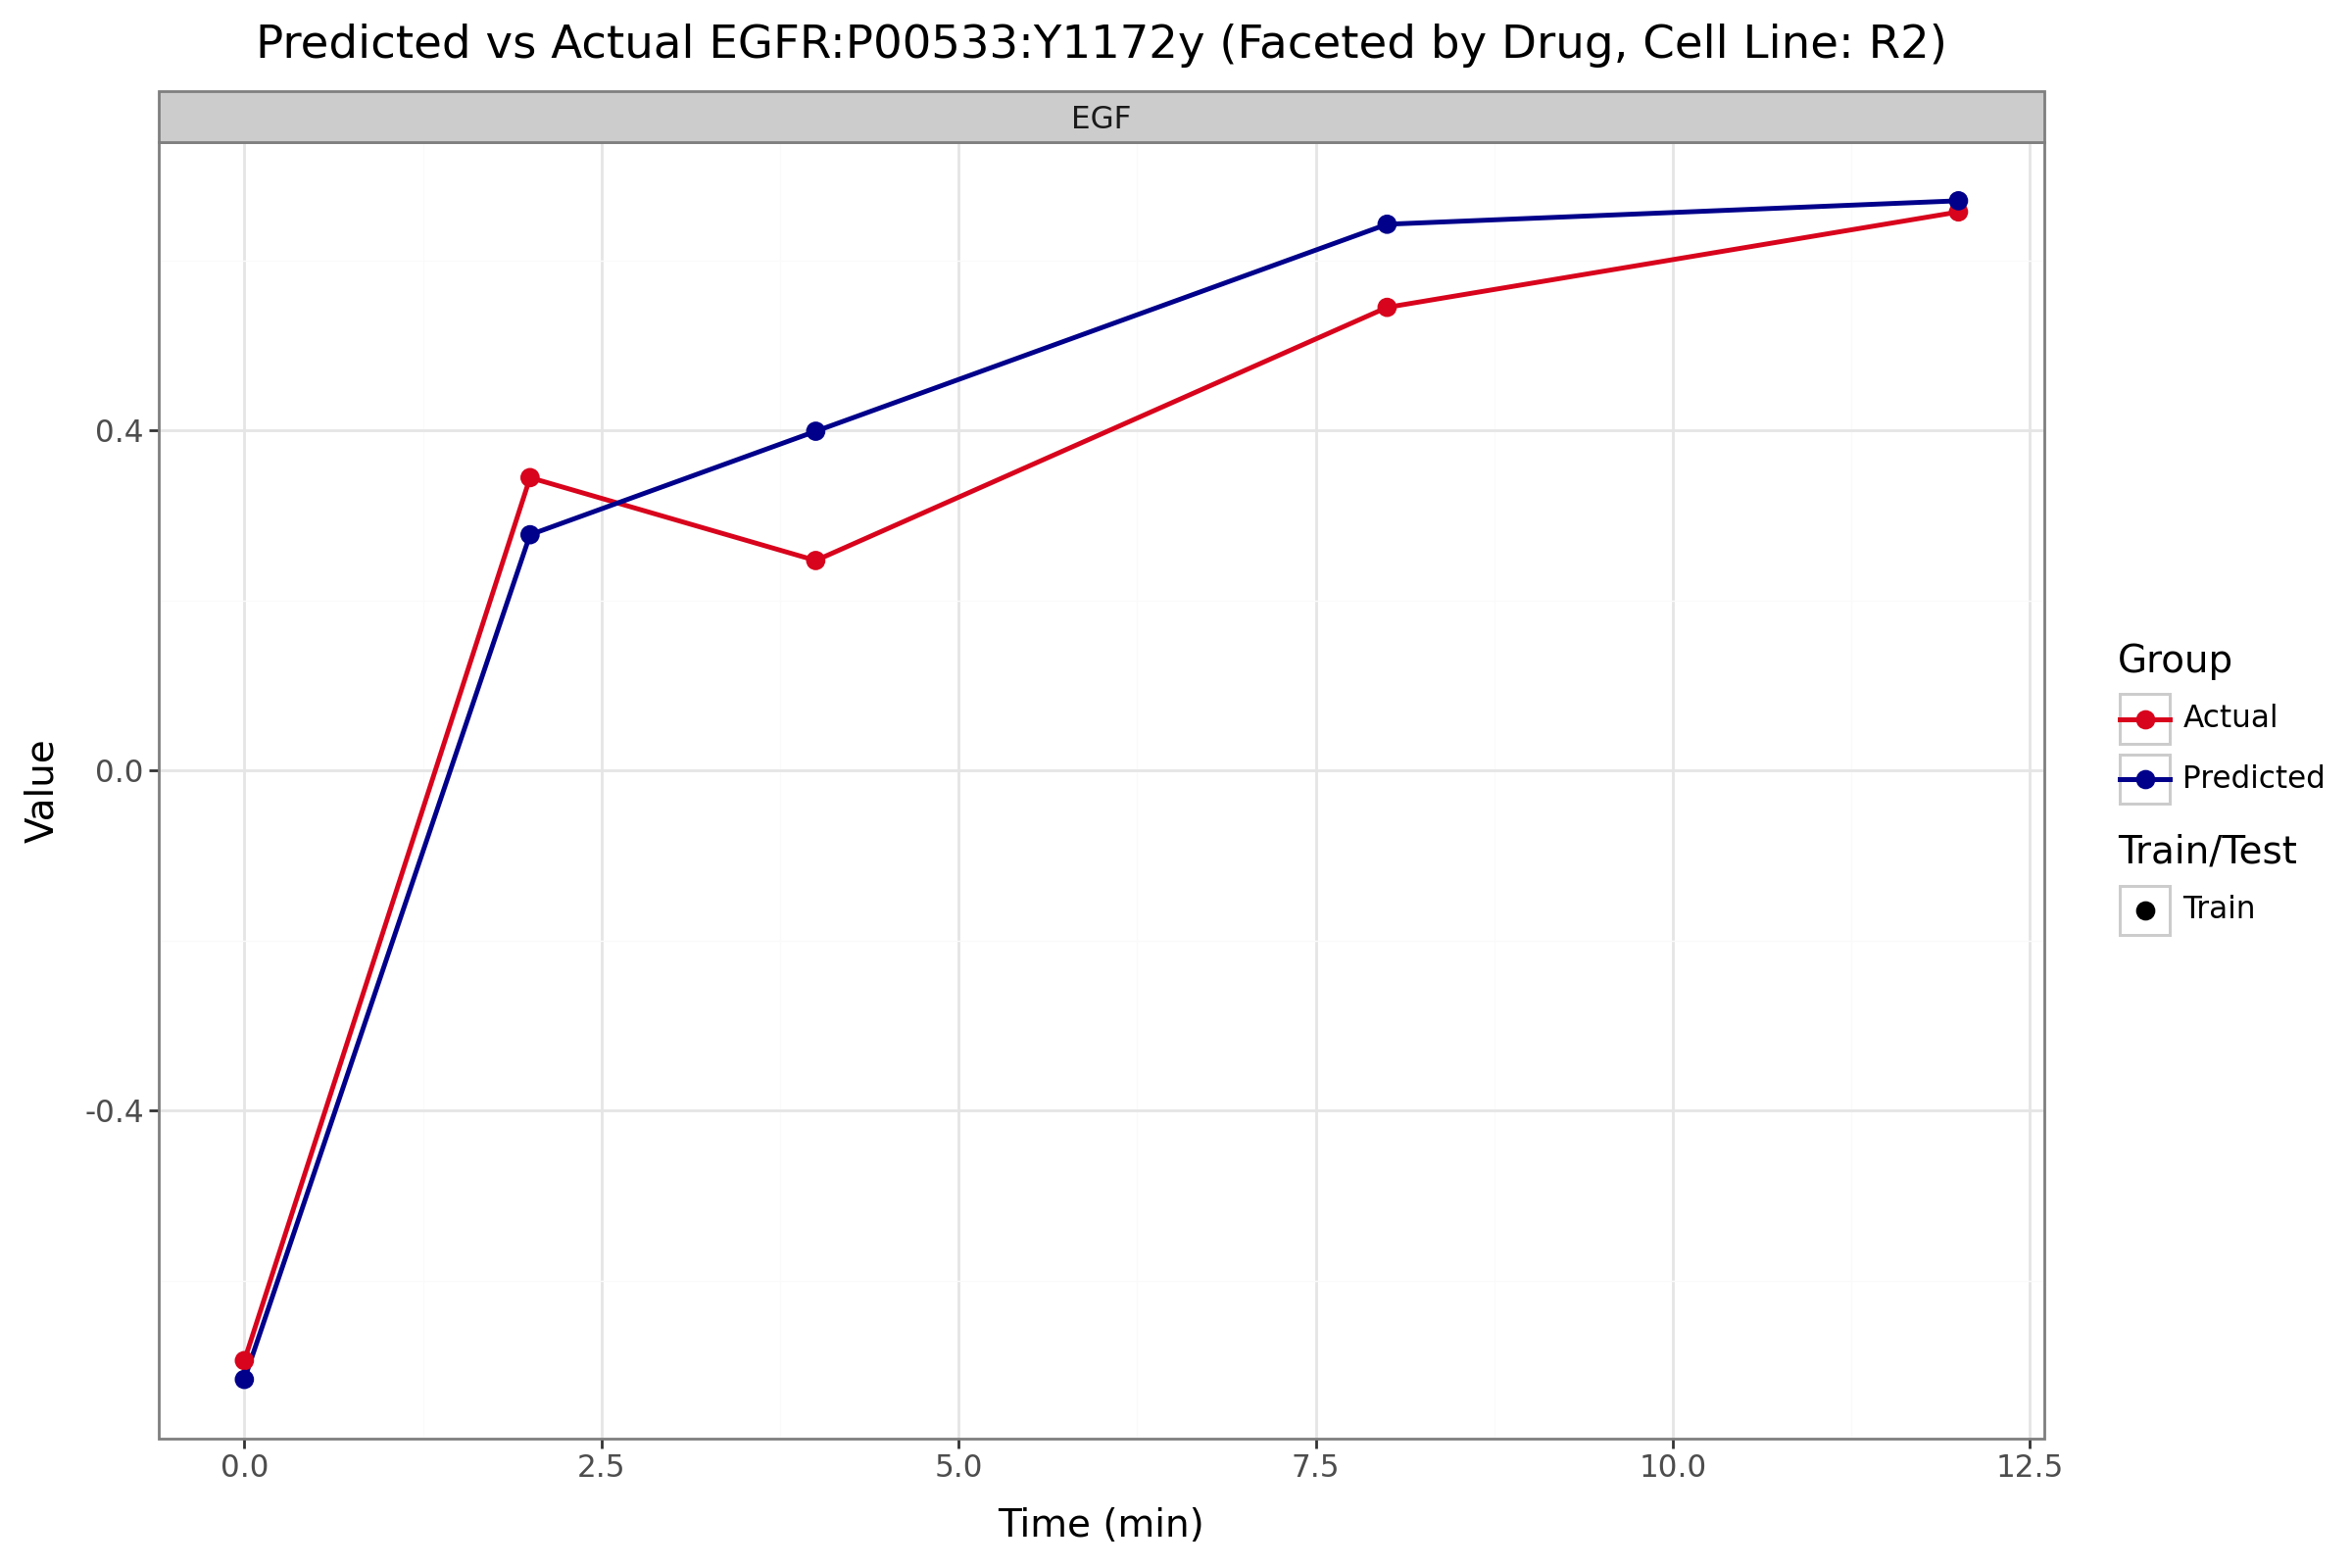

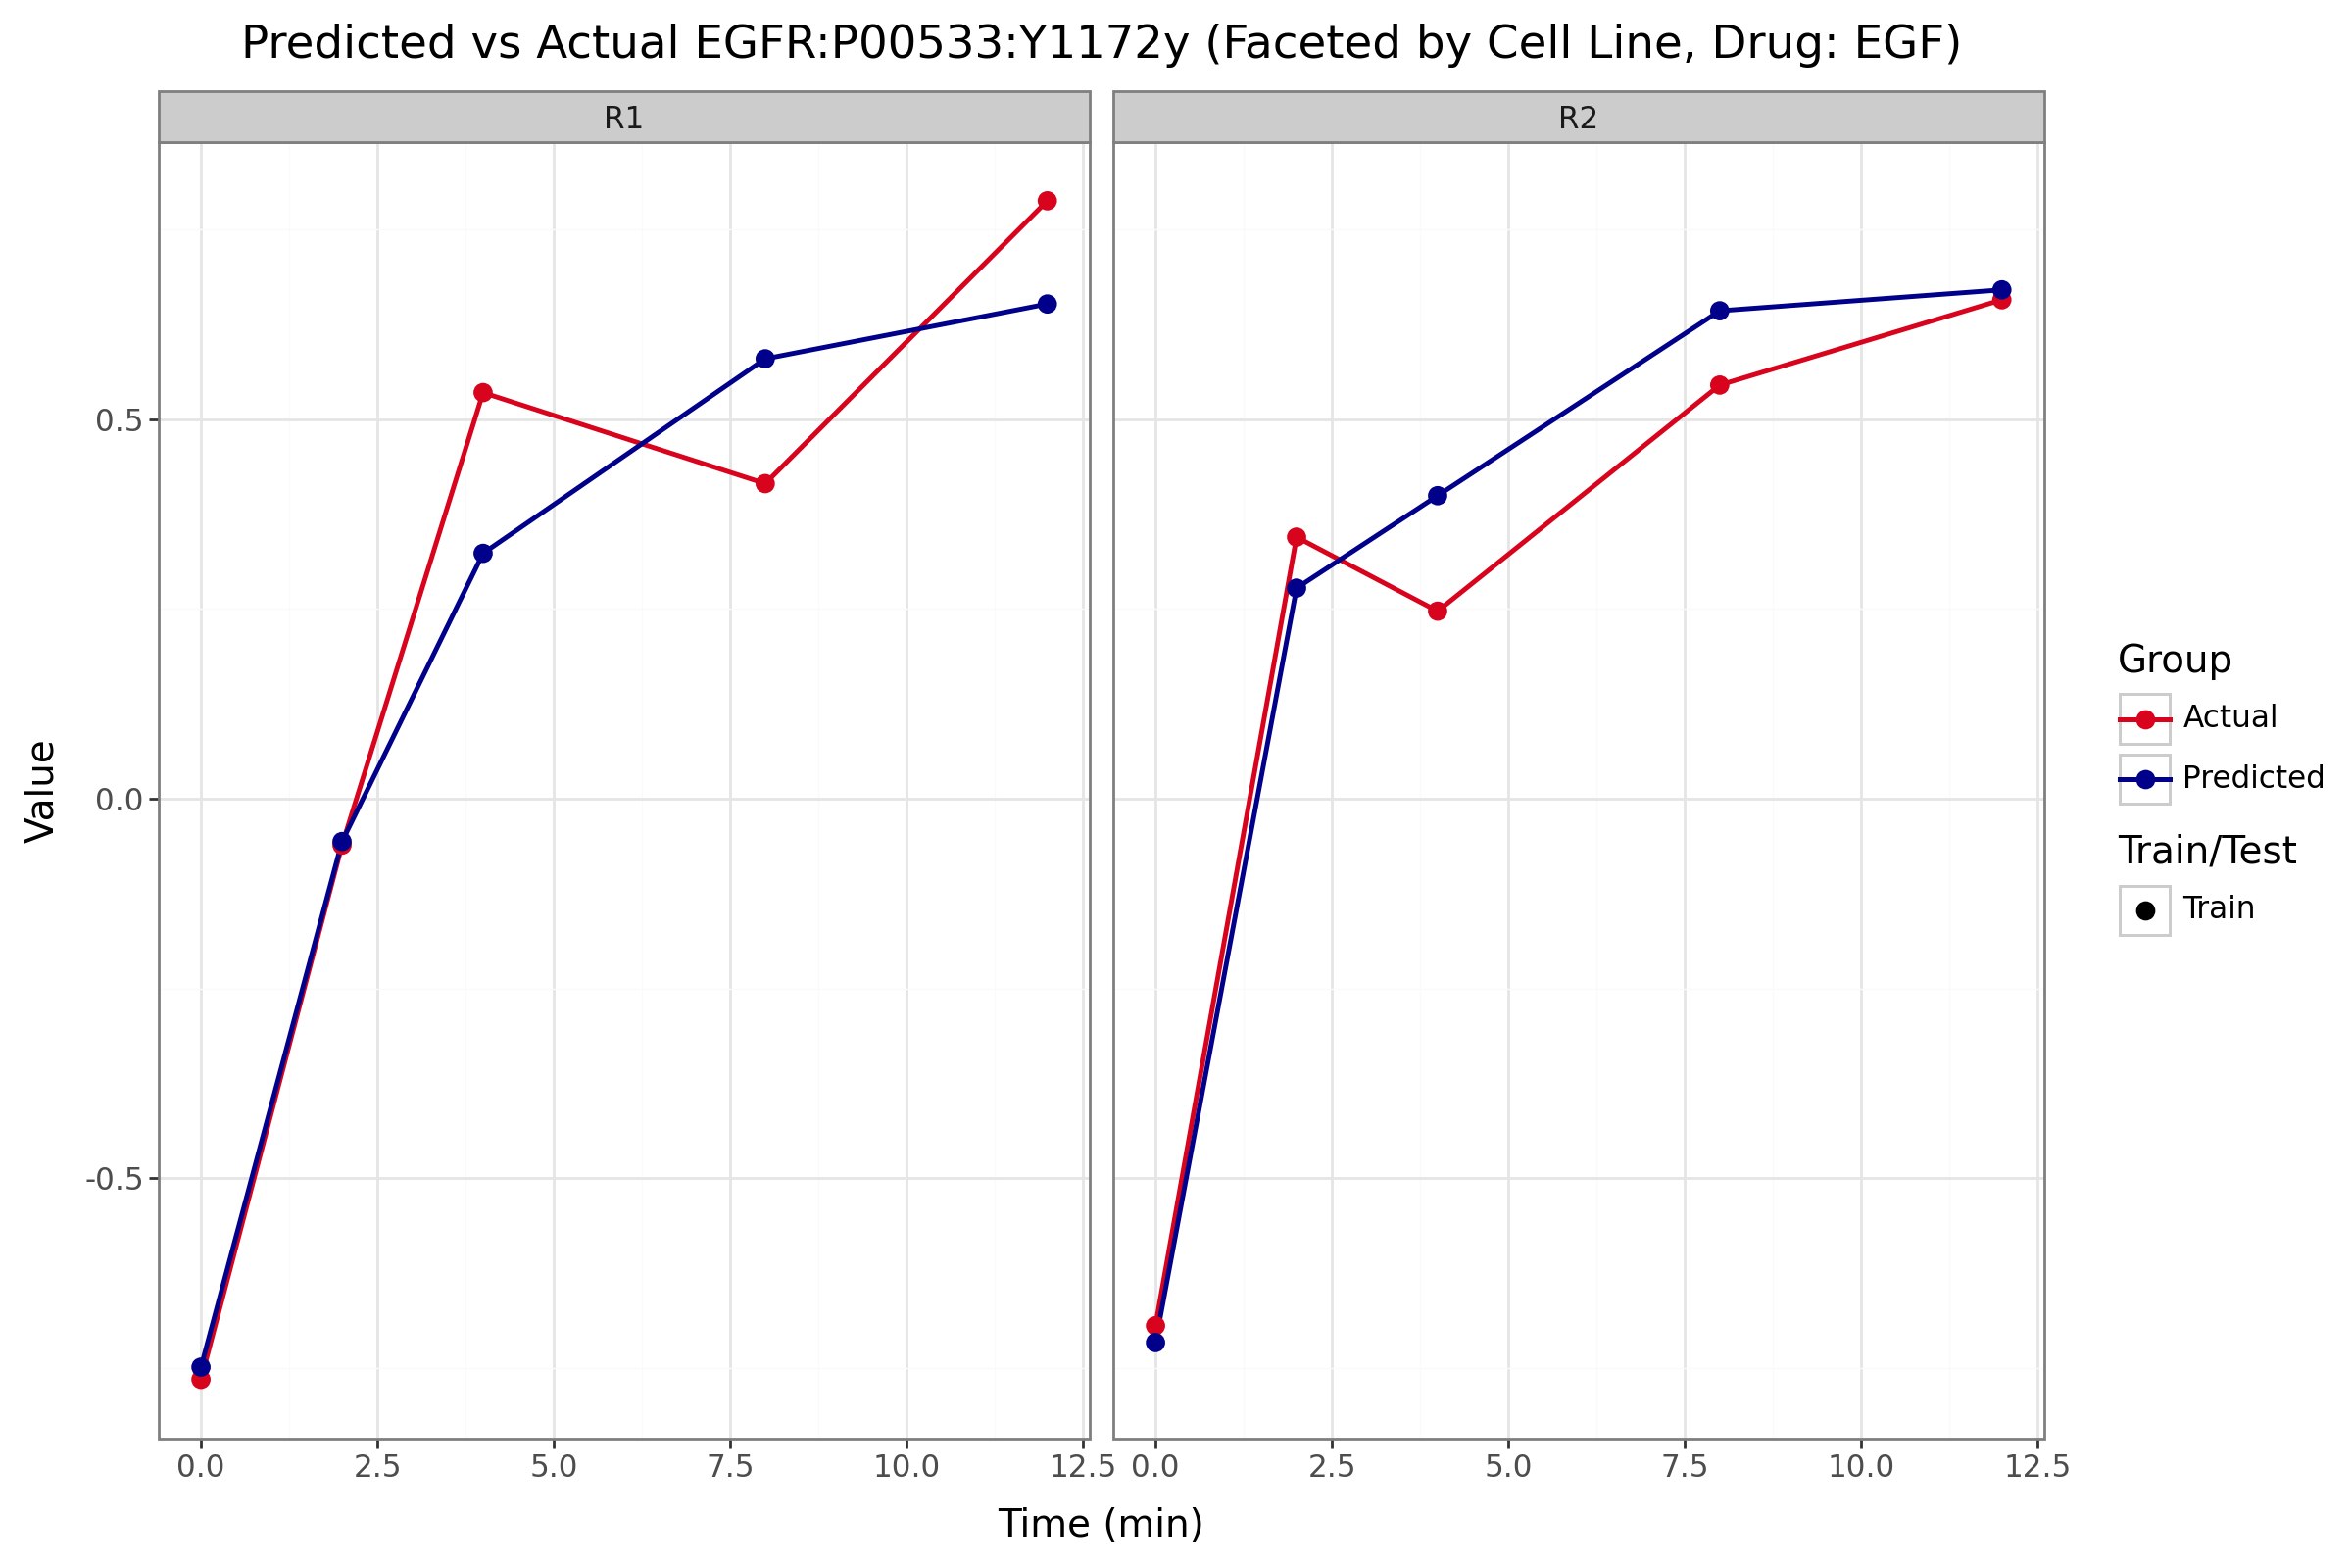

In [26]:
drug_input = "EGF"
cl_input = "R2"
phosphosite_input = "EGFR:P00533:Y1172y"  # BRAF:P15056:T753t, BRAF:P15056:S365s, MK01:P28482:T185t, MAPK2:P49137:T334t, SHC1:P29353:S139s, SHC1:P29353:S41s, SHC1:P29353:S453s, SHC1:P29353:Y349y, SHC1:P29353:Y350y, SHC1:P29353:Y427y, PTN11:Q06124:S142s, PTN11:Q06124:S562s, PTN11:Q06124:Y546y, PTN11:Q06124:Y62y, GAB1:Q13480:S209s, GAB1:Q13480:S266s, GAB1:Q13480:S274s, GAB1:Q13480:S355s, GAB1:Q13480:S401s, GAB1:Q13480:S419s, GAB1:Q13480:S500s, GAB1:Q13480:S551s, GAB1:Q13480:S634s, GAB1:Q13480:S650s, GAB1:Q13480:S651s, GAB1:Q13480:T199t, GAB1:Q13480:T211t, GAB1:Q13480:T365t, GAB1:Q13480:T377t, GAB1:Q13480:T390t, GAB1:Q13480:T503t, GAB1:Q13480:T638t, GAB1:Q13480:Y259y, GAB1:Q13480:Y285y, GAB1:Q13480:Y406y, GAB1:Q13480:Y447y, GAB1:Q13480:Y627y, GAB1:Q13480:Y659y
x_values = [0, 2, 4, 8, 12]  #[0, 5, 15, 60, 360, 1440, 2880, 5760]
Y_plot = Y_fullFull[:, [0, 2, 4, 8, 12], :]
y_out = mod.df_to_tensor(mod.y_out)
#Y_plot = subsample_Y(Y_fullFull, floor_idx, ceil_idx, weight)
Y_plot = Y_plot.permute(1, 0, 2)
Y_plot = torch.flatten(Y_plot, start_dim=0, end_dim=1)

# Prepare the Y_actual
y_actual = y_data.reset_index().rename(columns={"index": "Drug_CL_Time"})
display(y_actual.head())
y_actual[['Drug', 'CL', 'Time']] = y_actual['Drug_CL_Time'].str.split('_', expand=True)
y_actual['Time'] = y_actual['Time'].astype(int)

df_cell = y_actual[y_actual['CL'] == cl_input].copy()
df_drug = y_actual[y_actual['Drug'] == drug_input].copy()

df_cell['Group'] = df_cell['Drug_CL_Time'].isin(y_train_index).map({True: "Train", False: "Test"})
df_drug['Group'] = df_drug['Drug_CL_Time'].isin(y_train_index).map({True: "Train", False: "Test"})

# Sort the DataFrames by time for clarity.
df_cell = df_cell.sort_values(by=['Drug', 'CL', 'Time'])
df_drug = df_drug.sort_values(by=['Drug', 'CL', 'Time'])

cell_conditions = df_cell['Drug_CL_Time'].tolist()
drug_conditions = df_drug['Drug_CL_Time'].tolist()
display(df_cell.head())
cell_indices = [y_data.index.get_loc(cond) for cond in cell_conditions]
drug_indices = [y_data.index.get_loc(cond) for cond in drug_conditions]

phosphosite_idx = y_data.columns.get_loc(phosphosite_input)

# For the cell subset:
Y_cell_site = Y_plot[cell_indices, phosphosite_idx]
print(Y_cell_site.shape)
Drug, CL, Time = zip(*[cond.split('_') for cond in cell_conditions])
Time = list(map(int, Time))  
Drug = list(Drug)
df_cell_pred = pd.DataFrame({
    'X': Time,
    'Y': Y_cell_site.detach().cpu().numpy(),
    'Drug': Drug
})

# For the drug subset:
Y_drug_site = Y_plot[drug_indices, phosphosite_idx]

Drug, CL, Time = zip(*[cond.split('_') for cond in drug_conditions])
Time = list(map(int, Time))  
Drug = list(Drug)
df_drug_pred = pd.DataFrame({
    'X': Time,
    'Y': Y_drug_site.detach().cpu().numpy(),
    'CL': CL
})

# Create the actual data
df_cell = df_cell[df_cell['Drug_CL_Time'].isin(cell_conditions)]
df_cell["Train/Test"] = df_cell["Drug_CL_Time"].isin(y_train_index).map({True: "Train", False: "Test"})
df_cell = df_cell[['Time', phosphosite_input, 'Drug', "Train/Test"]]
df_cell = df_cell.rename(columns={"Time": "X", phosphosite_input: "Y"})
df_cell["Group"] = "Actual"

df_drug = df_drug[df_drug['Drug_CL_Time'].isin(drug_conditions)]
df_drug["Train/Test"] = df_drug["Drug_CL_Time"].isin(y_train_index).map({True: "Train", False: "Test"})
df_drug = df_drug[['Time', phosphosite_input, 'CL', "Train/Test"]]
df_drug = df_drug.rename(columns={"Time": "X", phosphosite_input: "Y"})
df_drug["Group"] = "Actual"

df_cell_pred['Train/Test'] = df_cell['Train/Test'].reset_index(drop=True)
df_cell_pred['Group'] = "Predicted"
df_drug_pred['Train/Test'] = df_drug['Train/Test'].reset_index(drop=True)
df_drug_pred['Group'] = "Predicted"

df_cell_plot = pd.concat([df_cell, df_cell_pred], axis=0)
df_drug_plot = pd.concat([df_drug, df_drug_pred], axis=0)

# Plot A: Facet by Drug (for the specified cell line)
plot_A = (
    p9.ggplot(df_cell_plot, p9.aes(x='X', y='Y', color='Group', shape='Train/Test'))
    + p9.geom_line(size=1)
    + p9.geom_point(size=3)
    + p9.facet_wrap('~ Drug')
    + p9.scale_color_manual(values={'Predicted': 'darkblue', 'Actual': '#d8031c'})
    + p9.scale_shape_manual(values={'Train': 'o', 'Test': 's'})
    #+ p9.scale_x_log10()
    + p9.labs(title=f"Predicted vs Actual {phosphosite_input} (Faceted by Drug, Cell Line: {cl_input})", x="Time (min)", y="Value")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(12,8), legend_position='right')
)
plot_A.show()

# Plot B: Facet by Cell Line (for the specified drug)
plot_B = (
    p9.ggplot(df_drug_plot, p9.aes(x='X', y='Y', color='Group', shape='Train/Test'))
    + p9.geom_line(size=1)
    + p9.geom_point(size=3)
    + p9.facet_wrap('~ CL')
    + p9.scale_color_manual(values={'Predicted': 'darkblue', 'Actual': '#d8031c'})
    + p9.scale_shape_manual(values={'Train': 'o', 'Test': 's'})
    #+ p9.scale_x_log10()
    + p9.labs(title=f"Predicted vs Actual {phosphosite_input} (Faceted by Cell Line, Drug: {drug_input})", x="Time (min)", y="Value")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(12,8), legend_position='right')
)
plot_B.show()
